## Adversarial Attacks on Image Classifiers - Final Project

### Imports and Setup

In [1]:
!pip install lpips -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.8 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is inc

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import json
import os
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import random
import time
from PIL import Image
import torch.nn.functional as F
import lpips

In [3]:
# --- Configuration ---
DATASET_PATH = "/kaggle/input/testdataset/TestDataSet" # Path to the ImageFolder dataset
JSON_PATH = "/kaggle/input/imagenetjson/imagenet_class_index.json" # Path to the STANDARD ImageNet class index JSON file
BATCH_SIZE = 32 # Adjust based on your system's memory

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Helper/Utility Functions

In [4]:
def denormalize(tensor, mean, std):
    """Denormalizes a tensor image with mean and standard deviation."""
    # Clone the tensor to avoid modifying the original data
    denorm_tensor = tensor.clone()
    # Ensure mean and std are tensors and correctly shaped for broadcasting
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device).view(-1, 1, 1)

    denorm_tensor.mul_(std).add_(mean)

    # Ensure the tensor values are in the valid range [0, 1]
    denorm_tensor = torch.clamp(denorm_tensor, 0, 1)
    return denorm_tensor

In [5]:
def calculate_accuracy(model, dataloader, device, imagefolder_idx_to_imagenet_idx_map):
    """Calculates top-1 and top-5 accuracy of a model on a given dataset."""
    model.eval() # Ensure model is in evaluation mode
    
    total = 0
    correct_top1 = 0
    correct_top5 = 0

    with torch.no_grad(): # Disable gradient calculations for efficiency
        # Wrap dataloader with tqdm for a progress bar
        for inputs, labels_imagefolder in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            # We don't move labels_imagefolder to device, as comparison happens on CPU side
            # labels_imagefolder contains the 0-99 indices from ImageFolder

            # Get model predictions (logits)
            outputs = model(inputs)
            # Get the top 5 predictions (indices and values)
            _, predicted_top5_imagenet = torch.topk(outputs, 5, dim=1)
            predicted_top5_imagenet = predicted_top5_imagenet.cpu() # Move predictions to CPU

            # Get the true ImageNet labels for this batch
            # Map the ImageFolder labels (0-99) to the actual ImageNet labels (0-999)
            true_labels_imagenet = torch.tensor(
                [imagefolder_idx_to_imagenet_idx_map.get(lbl.item(), -1) for lbl in labels_imagefolder],
                dtype=torch.long
            )
            # Filter out any labels that couldn't be mapped (assigned -1)
            valid_mask = true_labels_imagenet != -1
            # if not valid_mask.all():
            #      print(f"Warning: Skipping { (~valid_mask).sum() } samples due to missing label mapping.")

            # Only consider samples where the true label could be mapped
            predicted_top5_imagenet = predicted_top5_imagenet[valid_mask]
            true_labels_imagenet = true_labels_imagenet[valid_mask]
            
            if true_labels_imagenet.numel() == 0: # Skip batch if no valid labels
                continue

            total += true_labels_imagenet.size(0)

            # Check Top-1 accuracy
            correct_top1 += (predicted_top5_imagenet[:, 0] == true_labels_imagenet).sum().item()

            # Check Top-5 accuracy
            # For each true label, check if it's present in the top 5 predictions
            correct_top5 += (predicted_top5_imagenet == true_labels_imagenet.unsqueeze(1)).any(dim=1).sum().item()

    if total == 0:
        print("Error: No valid samples found for evaluation. Check label mapping.")
        return 0.0, 0.0

    # Calculate final accuracies
    accuracy_top1 = 100 * correct_top1 / total
    accuracy_top5 = 100 * correct_top5 / total

    return accuracy_top1, accuracy_top5

In [6]:
def get_prediction(model, image_tensor, device, imagenet_idx_to_info_map):
    """Gets the top-1 prediction for a single image tensor."""
    model.eval()
    with torch.no_grad():
        input_tensor = image_tensor.unsqueeze(0).to(device)
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        top_prob, top_idx = torch.topk(probabilities, 1, dim=1)
        
        idx = top_idx.item()
        prob = top_prob.item()
        
        # Handle potential variations in JSON value format ([id, name] or just name)
        info = imagenet_idx_to_info_map.get(str(idx), ["N/A", "Unknown Index"])
        name = info[1] if isinstance(info, list) and len(info) > 1 else str(info)
        class_name = name.split(',')[0] # Take first part of name if multiple exist
        
        return idx, class_name, prob

In [7]:
def visualize_predictions(model, dataset, num_images, imagefolder_idx_to_imagenet_idx_map, imagenet_idx_to_info_map, device, mean_norms, std_norms):
    """Displays predictions for a few random images from the dataset."""
    model.eval()
    
    # Get random indices for visualization
    num_total_images = len(dataset)
    if num_images > num_total_images:
        num_images = num_total_images
        print(f"Warning: Requested {num_images} images for visualization, but dataset only has {num_total_images}. Showing all.")
    
    random_indices = random.sample(range(num_total_images), num_images)
    
    print(f"\n--- Visualizing Predictions for {num_images} Random Images ---")

    for i, idx in enumerate(random_indices):
        # Get the preprocessed image and its ImageFolder label (0-99)
        image_tensor, label_imagefolder = dataset[idx]
        
        # Find the true ImageNet index (0-999) using the mapping
        true_imagenet_idx = imagefolder_idx_to_imagenet_idx_map.get(label_imagefolder, -1)
        
        if true_imagenet_idx == -1:
            print(f"Skipping visualization for sample {idx}: True ImageNet label not found.")
            continue
            
        # Find the true class name from the standard mapping
        true_info = imagenet_idx_to_info_map.get(str(true_imagenet_idx), ["N/A", "Unknown Label"])
        true_class_name = true_info[1] if isinstance(true_info, list) and len(true_info) > 1 else str(true_info)
        true_class_name = true_class_name.split(',')[0] # Take first part of name if multiple exist

        # Prepare image for model (add batch dimension and move to device)
        input_tensor = image_tensor.unsqueeze(0).to(device)

        # Get model predictions
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            top5_prob, top5_indices = torch.topk(probabilities, 5, dim=1)

        # Move results to CPU and convert to numpy
        top5_prob = top5_prob.squeeze().cpu().numpy()
        top5_indices = top5_indices.squeeze().cpu().numpy()

        # Get the predicted class names
        pred_class_names = []
        for imagenet_idx in top5_indices:
            info = imagenet_idx_to_info_map.get(str(imagenet_idx), ["N/A", "Unknown Index"])
            name = info[1] if isinstance(info, list) and len(info) > 1 else str(info)
            pred_class_names.append(name.split(',')[0]) # Take first part

        # Denormalize image for display
        display_image = denormalize(image_tensor.cpu(), mean_norms, std_norms)
        # Convert from (C, H, W) to (H, W, C) for matplotlib
        display_image = display_image.permute(1, 2, 0).numpy() 

        # Create plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Display Image
        axes[0].imshow(display_image)
        axes[0].set_title(f"True Label: {true_class_name}\n(Index: {true_imagenet_idx})")
        axes[0].axis('off')

        # Display Bar Chart of Predictions
        axes[1].barh(np.arange(5), top5_prob, align='center')
        axes[1].set_yticks(np.arange(5))
        axes[1].set_yticklabels(pred_class_names)
        axes[1].invert_yaxis() # Display top prediction at the top
        axes[1].set_xlabel("Probability")
        axes[1].set_title("Top 5 Predictions")
        axes[1].set_xlim(0, 1) # Probabilities are between 0 and 1

        plt.suptitle(f"Sample {i+1} (Dataset Index: {idx})")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()

In [8]:
def save_adversarial_images(adv_data_path, original_dataset, output_root_dir, mean_norms, std_norms):
    """
    Loads adversarial tensors, denormalizes them, and saves as images.
    Args:
        adv_data_path (str): Path to the .pth file containing {'tensors': ..., 'labels': ..., 'original_indices': ...}.
        original_dataset (torchvision.datasets.ImageFolder): The original dataset used in Task 1.
        output_root_dir (str): The root directory to save the adversarial images.
        mean_norms (np.array): Mean values used for normalization.
        std_norms (np.array): Std deviation values used for normalization.
    """
    print(f"\nLoading adversarial data from: {adv_data_path}")
    if not os.path.exists(adv_data_path):
        print(f"Error: File not found at {adv_data_path}")
        return
        
    try:
        adv_data = torch.load(adv_data_path, map_location='cpu') # Load to CPU
        adv_tensors = adv_data['tensors']
        adv_orig_indices = adv_data['original_indices'] # Indices corresponding to original_dataset
        # adv_labels = adv_data['labels'] # We get labels from original_dataset
    except Exception as e:
        print(f"Error loading or parsing {adv_data_path}: {e}")
        return

    print(f"Loaded {len(adv_tensors)} adversarial tensors.")
    
    # Create the output directory
    os.makedirs(output_root_dir, exist_ok=True)
    print(f"Saving images to: {output_root_dir}")

    # Create a mapping from original index to adversarial tensor for quick lookup
    index_to_tensor_map = {orig_idx: tensor for orig_idx, tensor in zip(adv_orig_indices, adv_tensors)}

    # Define the transformation to convert tensor to PIL Image
    to_pil = transforms.ToPILImage()

    saved_count = 0
    # Iterate through the original dataset samples to get filenames and class folders
    for i, (original_filepath, original_class_index) in enumerate(tqdm(original_dataset.samples, desc=f"Saving Images to {os.path.basename(output_root_dir)}")):
        
        # Check if an adversarial tensor exists for this original index
        if i in index_to_tensor_map:
            adv_tensor = index_to_tensor_map[i]
            
            # Get class name (folder name like nXXXXXXXX)
            class_name = original_dataset.classes[original_class_index]
            
            # Create class directory if it doesn't exist
            class_dir = os.path.join(output_root_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            
            # Get original filename
            original_filename = os.path.basename(original_filepath)
            output_filename = original_filename 
            output_filepath = os.path.join(class_dir, output_filename)
            
            try:
                # Denormalize the adversarial tensor
                denorm_tensor = denormalize(adv_tensor.cpu(), mean_norms, std_norms) # Ensure tensor on CPU
                
                # Convert tensor to PIL Image (expects CxHxW, float 0-1)
                pil_image = to_pil(denorm_tensor)
                
                # Save the PIL Image
                pil_image.save(output_filepath)
                saved_count += 1
            except Exception as e:
                print(f"\nError processing or saving image for index {i}, file {output_filepath}: {e}")

    print(f"Finished saving. Saved {saved_count} images to {output_root_dir}")

### Task 1: Basics - Model Loading, Dataset Preprocessing, and Baseline Evaluation

In [9]:
# --- Check for Dataset and JSON ---
if not os.path.exists(DATASET_PATH):
    print(f"Error: Dataset path '{DATASET_PATH}' not found.")
    print("Please ensure the 'TestDataSet' folder exists and contains subfolders named with WordNet IDs (e.g., nXXXXXXXX).")
    exit()

if not os.path.exists(JSON_PATH):
    print(f"Error: JSON path '{JSON_PATH}' not found.")
    print("Please ensure the standard ImageNet class index JSON file exists at this location.")
    exit()

# --- Load Pre-trained ResNet-34 Model ---
print("Loading ResNet-34 model...")
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval() 
model.to(device) 
print("ResNet-34 model loaded successfully.")

# --- Image Preprocessing ---
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

preprocess_transforms = transforms.Compose([
    transforms.Resize(256),          
    transforms.CenterCrop(224),      
    transforms.ToTensor(),           
    transforms.Normalize(mean=mean_norms, std=std_norms) 
])

# --- Load Dataset ---
print(f"Loading dataset from '{DATASET_PATH}'...")
dataset = torchvision.datasets.ImageFolder(
    root=DATASET_PATH,
    transform=preprocess_transforms
)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2, 
    pin_memory=torch.cuda.is_available()
)
print(f"Dataset loaded: {len(dataset)} images found in {len(dataset.classes)} classes.")

# --- Load Label Mapping (from standard ImageNet JSON) ---
print(f"Loading standard ImageNet class index from '{JSON_PATH}'...")
with open(JSON_PATH, 'r') as f:
    try:
        imagenet_idx_to_info = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {JSON_PATH}: {e}")
        exit()
    except Exception as e:
        print(f"Error loading {JSON_PATH}: {e}")
        exit()

wordnet_id_to_imagenet_idx = {}
print("Parsing standard ImageNet JSON to map WordNet IDs to ImageNet indices...")
for imagenet_idx_str, info_list in imagenet_idx_to_info.items():
    if isinstance(info_list, list) and len(info_list) >= 1:
        wordnet_id = info_list[0] 
        try:
            imagenet_idx = int(imagenet_idx_str)
            wordnet_id_to_imagenet_idx[wordnet_id] = imagenet_idx
        except ValueError:
             print(f"Warning: Skipping entry with non-integer index: '{imagenet_idx_str}'")

if not wordnet_id_to_imagenet_idx:
    print(f"Error: Could not parse any valid WordNet ID to ImageNet Index mappings from {JSON_PATH}.")
    exit()
else:
    print(f"Parsed {len(wordnet_id_to_imagenet_idx)} WordNet ID to ImageNet index mappings.")


imagefolder_idx_to_imagenet_idx = {}
found_all_classes = True
print("Mapping ImageFolder indices (based on WordNet ID folders) to ImageNet indices...")
for folder_name_wordnet_id, imagefolder_idx in dataset.class_to_idx.items():
    if folder_name_wordnet_id in wordnet_id_to_imagenet_idx:
        imagenet_idx = wordnet_id_to_imagenet_idx[folder_name_wordnet_id]
        imagefolder_idx_to_imagenet_idx[imagefolder_idx] = imagenet_idx
    else:
        print(f"Warning: Could not find ImageNet index for folder (WordNet ID) '{folder_name_wordnet_id}' in parsed JSON data. This class will be skipped during evaluation.")
        found_all_classes = False

if not imagefolder_idx_to_imagenet_idx:
     print(f"Error: No classes could be mapped. Ensure folder names in '{DATASET_PATH}' are correct WordNet IDs present as the first element in the lists within '{JSON_PATH}'.")
     exit()
elif not found_all_classes:
     print("Warning: Not all class folders in TestDataSet could be mapped to ImageNet indices. Accuracy will be calculated only on mapped classes.")
else:
    print("Successfully mapped all dataset folder indices to ImageNet indices.")

# --- Run Evaluation ---
print("\nStarting evaluation on the original test dataset...")
task1_top1_accuracy, task1_top5_accuracy = calculate_accuracy(
    model,
    dataloader,
    device,
    imagefolder_idx_to_imagenet_idx 
)

# --- Report Results ---
print("\n--- Task 1 Results ---")
print(f"Dataset: Original Test Set ({len(dataset)} images from {DATASET_PATH})")
print(f"Model: ResNet-34 (ImageNet pre-trained)")
print(f"Top-1 Accuracy: {task1_top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {task1_top5_accuracy:.2f}%")
print("----------------------")

# --- Optional: Visualize some predictions from original dataset ---
# NUM_IMAGES_TO_SHOW_TASK1 = 3
# visualize_predictions(model, dataset, NUM_IMAGES_TO_SHOW_TASK1, imagefolder_idx_to_imagenet_idx, imagenet_idx_to_info, device, mean_norms, std_norms)

Loading ResNet-34 model...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 182MB/s] 


ResNet-34 model loaded successfully.
Loading dataset from '/kaggle/input/testdataset/TestDataSet'...
Dataset loaded: 500 images found in 100 classes.
Loading standard ImageNet class index from '/kaggle/input/imagenetjson/imagenet_class_index.json'...
Parsing standard ImageNet JSON to map WordNet IDs to ImageNet indices...
Parsed 1000 WordNet ID to ImageNet index mappings.
Mapping ImageFolder indices (based on WordNet ID folders) to ImageNet indices...
Successfully mapped all dataset folder indices to ImageNet indices.

Starting evaluation on the original test dataset...


Evaluating: 100%|██████████| 16/16 [00:02<00:00,  6.68it/s]


--- Task 1 Results ---
Dataset: Original Test Set (500 images from /kaggle/input/testdataset/TestDataSet)
Model: ResNet-34 (ImageNet pre-trained)
Top-1 Accuracy: 70.40%
Top-5 Accuracy: 93.20%
----------------------


### Task 2: Pixel-wise Attacks (FGSM)

In [10]:
# --- Task 2 Configuration ---
epsilon_fgsm = 0.02  # Attack budget for L-infinity norm
ADV_DATASET_SAVE_PATH = "./adversarial_test_set_1.pth" # Path to save the adversarial dataset tensors

In [11]:
def fgsm_attack(model, loss_fn, images, labels, epsilon, device):
    """
    Performs the FGSM attack on a batch of images.
    Args:
        model: The model to attack.
        loss_fn: Loss function (e.g., nn.CrossEntropyLoss).
        images: Batch of input images (normalized tensors).
        labels: Batch of true labels (ImageNet indices).
        epsilon: Attack budget (L-infinity norm).
        device: CPU or GPU.

    Returns:
        perturbed_images: Batch of adversarial images (tensors).
    """
    # Ensure images requires gradients
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    images.requires_grad = True

    # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, labels)

    # Backward pass to get gradients w.r.t. images
    model.zero_grad()
    loss.backward()

    # Collect the gradient data
    gradient = images.grad.data

    # Create the perturbed image by adjusting each pixel based on the sign of the gradient
    perturbed_images = images + epsilon * gradient.sign()
        
    # Detach the perturbed images from the computation graph
    perturbed_images = perturbed_images.detach()

    return perturbed_images

In [12]:
def visualize_attack(title_prefix, model, dataset, adv_tensors_map, index, 
                      imagefolder_idx_to_imagenet_idx_map, 
                      imagenet_idx_to_info_map, device, epsilon_val, mean_norms, std_norms):
    """Visualizes an attack: original, noise, adversarial image, and predictions."""
    model.eval()
    
    # Get original image and label
    original_image, label_imagefolder = dataset[index]
    true_imagenet_idx = imagefolder_idx_to_imagenet_idx_map.get(label_imagefolder, -1)
    if true_imagenet_idx == -1: 
        print(f"Skipping visualization for index {index}: true label not found.")
        return
    
    true_info = imagenet_idx_to_info_map.get(str(true_imagenet_idx), ["N/A", "Unknown Label"])
    true_class_name = true_info[1].split(',')[0] if isinstance(true_info, list) and len(true_info) > 1 else str(true_info)
    
    # Get adversarial image
    if index not in adv_tensors_map:
        print(f"Skipping visualization for index {index}: adversarial tensor not found.")
        return
    adversarial_image = adv_tensors_map[index]
    
    # Denormalize images
    img_orig_denorm = denormalize(original_image.cpu(), mean_norms, std_norms).permute(1, 2, 0).numpy()
    img_adv_denorm = denormalize(adversarial_image.cpu(), mean_norms, std_norms).permute(1, 2, 0).numpy()
    
    # Calculate perturbation (noise) and scale for visibility
    perturbation = adversarial_image.cpu() - original_image.cpu()
    # Scale noise: shift mean to 0.5, scale range. Adjust scaling factor as needed.
    noise_vis = perturbation / (2 * epsilon_val + 1e-9) + 0.5 # Add small constant to avoid division by zero if epsilon is 0
    noise_vis = torch.clamp(noise_vis, 0, 1)
    noise_vis_denorm = noise_vis.permute(1, 2, 0).numpy()

    # Get Top-5 predictions for the adversarial image
    with torch.no_grad():
        outputs = model(adversarial_image.unsqueeze(0).to(device))
        probabilities = torch.softmax(outputs, dim=1)
        top5_prob, top5_indices = torch.topk(probabilities, 5, dim=1)
        top5_prob = top5_prob.squeeze().cpu().numpy()
        top5_indices = top5_indices.squeeze().cpu().numpy()
        
    pred_class_names = []
    for idx_pred in top5_indices:
        info = imagenet_idx_to_info_map.get(str(idx_pred), ["N/A", "Unknown Index"])
        name = info[1] if isinstance(info, list) and len(info) > 1 else str(info)
        pred_class_names.append(name.split(',')[0])

    # Plotting
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original Image
    orig_pred_idx, orig_pred_name, _ = get_prediction(model, original_image, device, imagenet_idx_to_info)
    axes[0].imshow(img_orig_denorm)
    axes[0].set_title(f"Original\nTrue: {true_class_name}\nPred: {orig_pred_name} ({orig_pred_idx})")
    axes[0].axis('off')

    # Adversarial Noise
    axes[1].imshow(noise_vis_denorm)
    axes[1].set_title(f"Noise (eps={epsilon_val:.3f})\nScaled for visibility")
    axes[1].axis('off')

    # Adversarial Image
    adv_pred_idx, adv_pred_name, _ = get_prediction(model, adversarial_image, device, imagenet_idx_to_info)
    axes[2].imshow(img_adv_denorm)
    axes[2].set_title(f"Adversarial\nTrue: {true_class_name}\nPred: {adv_pred_name} ({adv_pred_idx})")
    axes[2].axis('off')

    # Prediction Bar Chart (for adversarial image)
    axes[3].barh(np.arange(5), top5_prob, align='center')
    axes[3].set_yticks(np.arange(5))
    axes[3].set_yticklabels(pred_class_names)
    axes[3].invert_yaxis() 
    axes[3].set_xlabel("Probability")
    axes[3].set_title("Top 5 Predictions (Adversarial)")
    axes[3].set_xlim(0, 1)

    plt.suptitle(f"{title_prefix} Attack Example (Original Dataset Index: {index})")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


--- Task 2: Generating Adversarial Dataset using FGSM ---


Generating FGSM: 100%|██████████| 16/16 [00:02<00:00,  6.05it/s]


Finished generating FGSM examples. Max L-inf distance observed: 0.020000
Saving adversarial dataset (FGSM) tensors to './adversarial_test_set_1.pth'...
FGSM adversarial dataset saved.

Evaluating model on Adversarial Test Set 1 (FGSM)...


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 31.82it/s]



--- Task 2 Results ---
Dataset: Adversarial Test Set 1 (FGSM, epsilon=0.02)
Model: ResNet-34 (ImageNet pre-trained)
Top-1 Accuracy: 5.00%
Top-5 Accuracy: 29.60%
----------------------

Finding examples of successful FGSM attacks for visualization...
Found 3 FGSM examples to visualize.


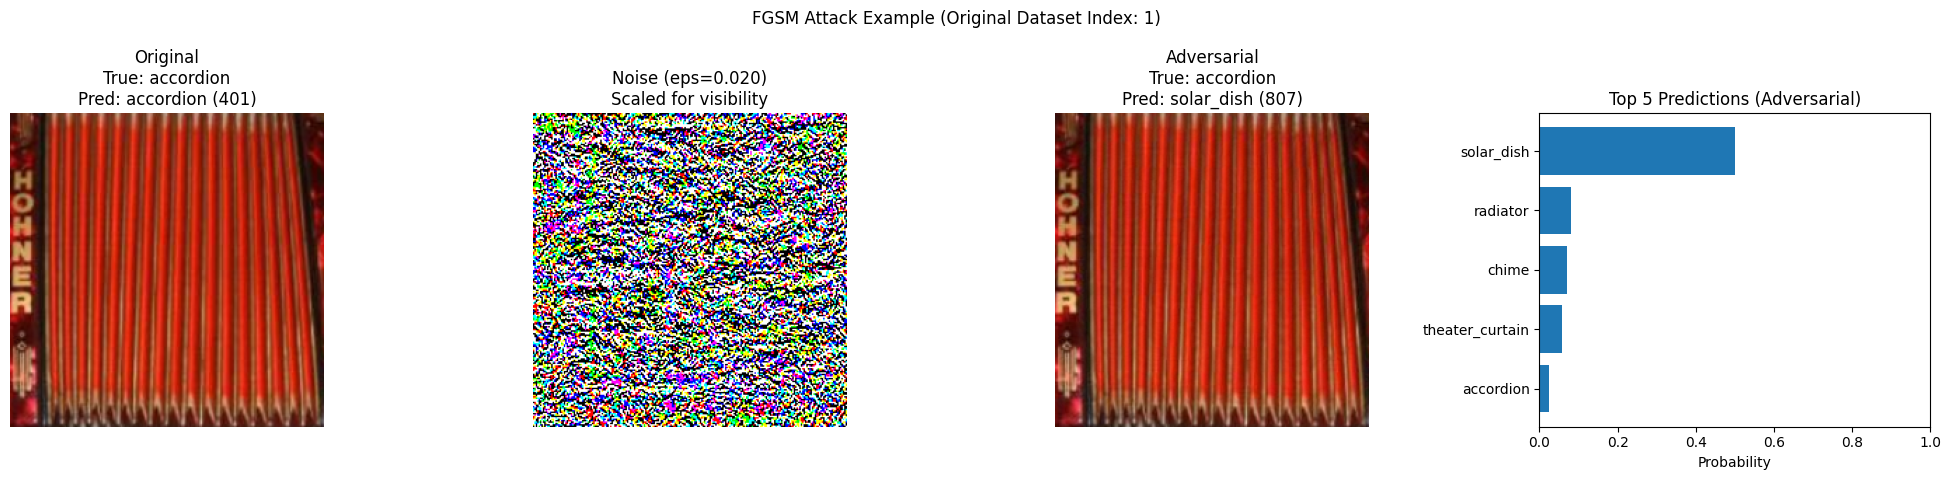

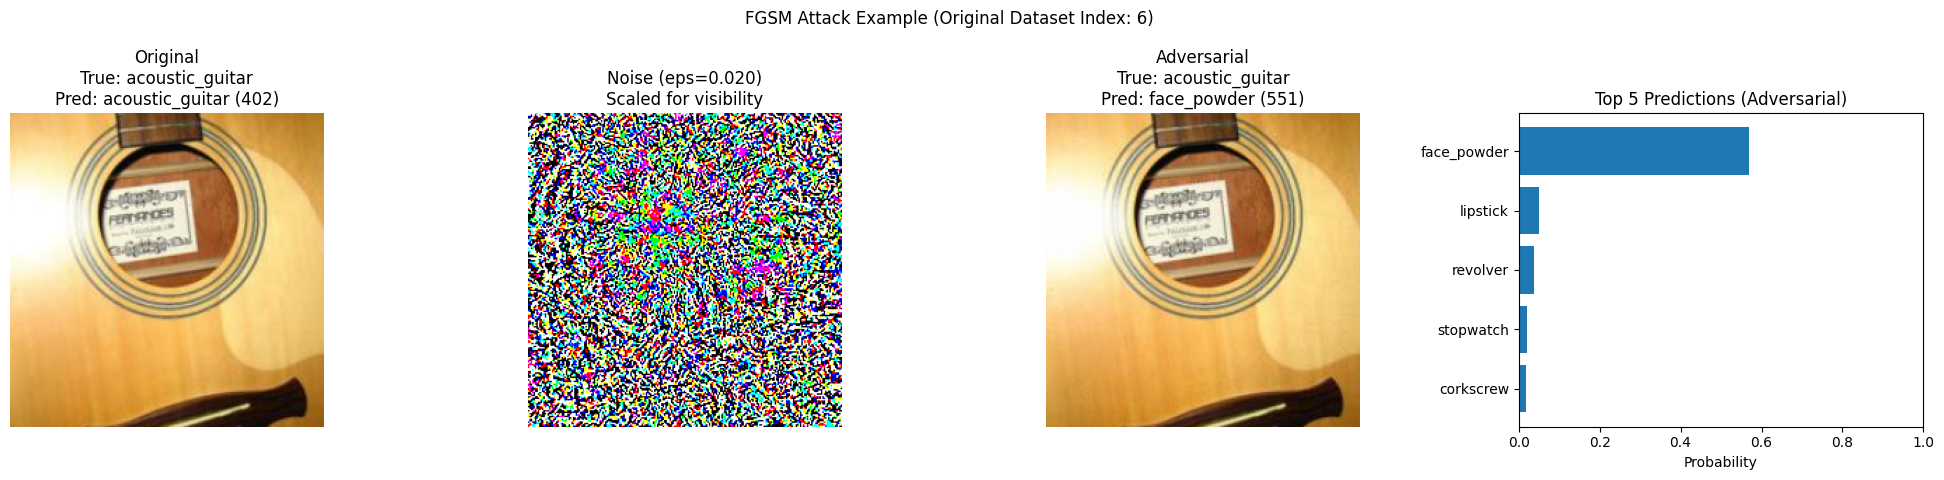

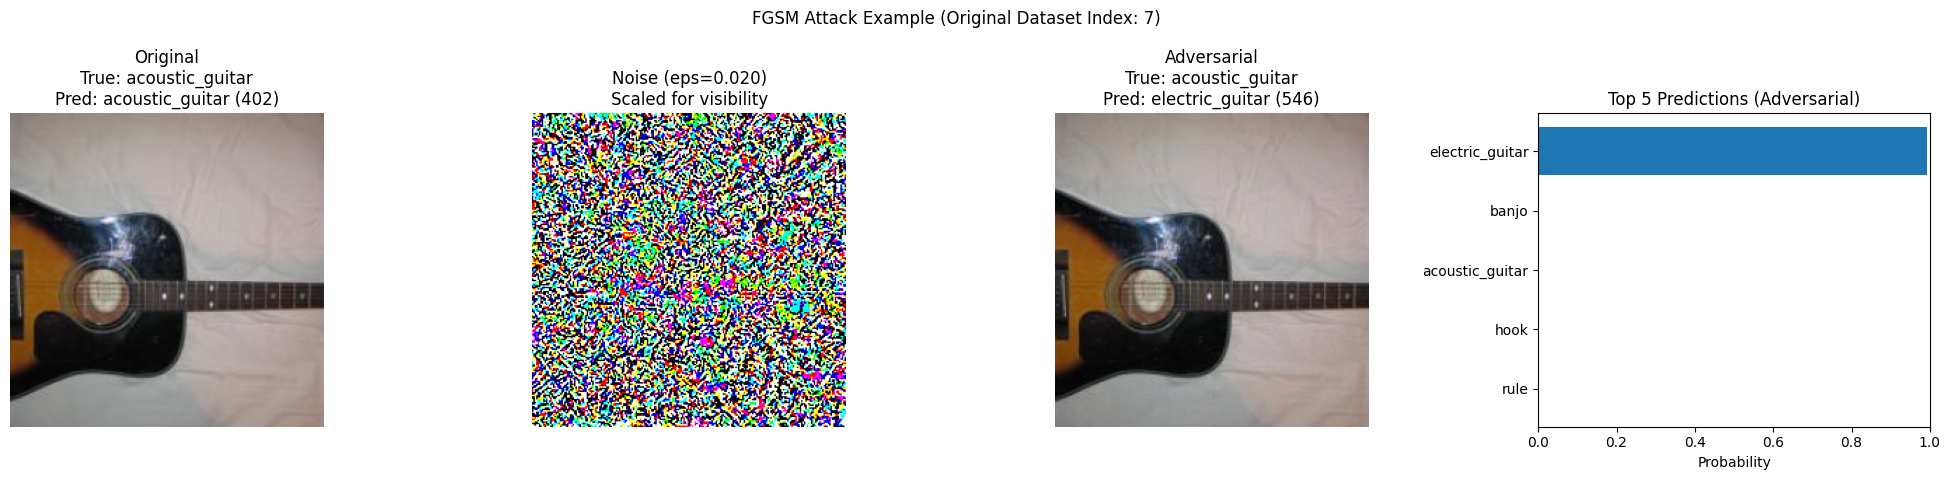

In [13]:
# --- Generate Adversarial Dataset (FGSM) ---
print("\n--- Task 2: Generating Adversarial Dataset using FGSM ---")
adversarial_tensors_fgsm = []
original_labels_list_fgsm = [] 
original_indices_list_fgsm = [] 

criterion_fgsm = nn.CrossEntropyLoss()
model.eval() 

batch_num_fgsm = 0
max_linf_observed_fgsm = 0.0

for images, labels_imagefolder in tqdm(dataloader, desc="Generating FGSM"):
    labels_imagenet = torch.tensor(
        [imagefolder_idx_to_imagenet_idx.get(lbl.item(), -1) for lbl in labels_imagefolder],
        dtype=torch.long
    )
    valid_mask = labels_imagenet != -1
    if not valid_mask.any():
        batch_num_fgsm += 1
        continue 

    images_valid = images[valid_mask]
    labels_imagenet_valid = labels_imagenet[valid_mask]
    labels_imagefolder_valid = labels_imagefolder[valid_mask]
    
    start_idx = batch_num_fgsm * BATCH_SIZE
    current_batch_indices = torch.arange(len(images))[valid_mask] + start_idx
    
    perturbed_batch = fgsm_attack(model, criterion_fgsm, images_valid, labels_imagenet_valid, epsilon_fgsm, device)

    delta = perturbed_batch.cpu() - images_valid.cpu()
    linf_distances = torch.linalg.norm(delta.flatten(start_dim=1), ord=float('inf'), dim=1)
    current_max_linf = torch.max(linf_distances).item()
    max_linf_observed_fgsm = max(max_linf_observed_fgsm, current_max_linf)

    if not torch.all(linf_distances <= epsilon_fgsm + 1e-6):
         print(f"\nWarning: L-inf constraint potentially violated in FGSM batch {batch_num_fgsm}. Max dist: {current_max_linf:.6f}")

    adversarial_tensors_fgsm.append(perturbed_batch.cpu())
    original_labels_list_fgsm.append(labels_imagefolder_valid.cpu())
    original_indices_list_fgsm.extend(current_batch_indices.tolist()) 
    
    batch_num_fgsm += 1

print(f"Finished generating FGSM examples. Max L-inf distance observed: {max_linf_observed_fgsm:.6f}")

if adversarial_tensors_fgsm: # Proceed only if list is not empty
    all_adversarial_tensors_fgsm = torch.cat(adversarial_tensors_fgsm)
    all_original_labels_fgsm = torch.cat(original_labels_list_fgsm)
    adv_dataset_fgsm = TensorDataset(all_adversarial_tensors_fgsm, all_original_labels_fgsm)

    print(f"Saving adversarial dataset (FGSM) tensors to '{ADV_DATASET_SAVE_PATH}'...")
    torch.save({
        'tensors': all_adversarial_tensors_fgsm,
        'labels': all_original_labels_fgsm, 
        'original_indices': original_indices_list_fgsm 
        }, ADV_DATASET_SAVE_PATH)
    print("FGSM adversarial dataset saved.")

    print("\nEvaluating model on Adversarial Test Set 1 (FGSM)...")
    adv_dataloader_fgsm = DataLoader(adv_dataset_fgsm, batch_size=BATCH_SIZE, shuffle=False)
    task2_top1_accuracy, task2_top5_accuracy = calculate_accuracy(
        model,
        adv_dataloader_fgsm,
        device,
        imagefolder_idx_to_imagenet_idx 
    )

    print("\n--- Task 2 Results ---")
    print(f"Dataset: Adversarial Test Set 1 (FGSM, epsilon={epsilon_fgsm})")
    print(f"Model: ResNet-34 (ImageNet pre-trained)")
    print(f"Top-1 Accuracy: {task2_top1_accuracy:.2f}%")
    print(f"Top-5 Accuracy: {task2_top5_accuracy:.2f}%")
    print("----------------------")

    # Visualize successful FGSM attacks
    print("\nFinding examples of successful FGSM attacks for visualization...")
    successful_attack_indices_fgsm = [] 
    num_to_visualize_fgsm = 3
    adv_tensors_map_fgsm = {orig_idx: adv_tensor for orig_idx, adv_tensor in zip(original_indices_list_fgsm, all_adversarial_tensors_fgsm)}

    checked_count_fgsm = 0
    for i in original_indices_list_fgsm: 
        if len(successful_attack_indices_fgsm) >= num_to_visualize_fgsm: break
        original_image, label_imagefolder_viz = dataset[i] 
        true_imagenet_idx_viz = imagefolder_idx_to_imagenet_idx.get(label_imagefolder_viz, -1)
        if true_imagenet_idx_viz == -1: continue
        if i not in adv_tensors_map_fgsm: continue
        adversarial_image_viz = adv_tensors_map_fgsm[i]
        orig_pred_idx_viz, _, _ = get_prediction(model, original_image, device, imagenet_idx_to_info)
        adv_pred_idx_viz, _, _ = get_prediction(model, adversarial_image_viz, device, imagenet_idx_to_info)
        if orig_pred_idx_viz == true_imagenet_idx_viz and adv_pred_idx_viz != true_imagenet_idx_viz:
            successful_attack_indices_fgsm.append(i)
        checked_count_fgsm += 1
        if checked_count_fgsm % 100 == 0: print(f"Checked {checked_count_fgsm}/{len(original_indices_list_fgsm)} for FGSM visualization...")
    print(f"Found {len(successful_attack_indices_fgsm)} FGSM examples to visualize.")
    for index_viz in successful_attack_indices_fgsm:
         visualize_attack("FGSM", model, dataset, adv_tensors_map_fgsm, index_viz, 
                          imagefolder_idx_to_imagenet_idx, imagenet_idx_to_info, 
                          device, epsilon_fgsm, mean_norms, std_norms)
else:
    print("FGSM adversarial dataset is empty. Skipping evaluation and visualization.")

### Task 3: Improved Attacks (I-FGSM / PGD)

In [14]:
# --- Task 3 Configuration ---
epsilon_ifgsm = 0.02       
num_iterations_ifgsm = 10  
alpha_ifgsm = 0.005      
ADV_DATASET2_SAVE_PATH = "./adversarial_test_set_2.pth"

In [15]:
def ifgsm_attack(model, loss_fn, images, labels, epsilon, alpha, num_iter, device):
    """
    Performs the Iterative FGSM (or basic PGD) attack on a batch of images.
    Args:
        model: The model to attack.
        loss_fn: Loss function (e.g., nn.CrossEntropyLoss).
        images: Batch of original input images (normalized tensors).
        labels: Batch of true labels (ImageNet indices).
        epsilon: Max L-infinity perturbation allowed.
        alpha: Step size for each iteration.
        num_iter: Number of iterations.
        device: CPU or GPU.

    Returns:
        perturbed_images: Batch of adversarial images (tensors).
    """
    images_orig = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)
    perturbed_images = images.clone().detach().to(device)

    for i in range(num_iter):
        perturbed_images.requires_grad = True
        outputs = model(perturbed_images)
        loss = loss_fn(outputs, labels)
        model.zero_grad()
        loss.backward()
        gradient = perturbed_images.grad.data
        perturbed_images = perturbed_images.detach() + alpha * gradient.sign()
        delta = torch.clamp(perturbed_images - images_orig, min=-epsilon, max=epsilon)
        perturbed_images = images_orig + delta
        
    perturbed_images = perturbed_images.detach()
    return perturbed_images


--- Task 3: Generating Adversarial Dataset using I-FGSM ---


Generating I-FGSM: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]


Finished generating I-FGSM adversarial examples. Max L-inf distance observed: 0.020000
Saving adversarial dataset (I-FGSM) tensors to './adversarial_test_set_2.pth'...
I-FGSM adversarial dataset saved.

Evaluating model on Adversarial Test Set 2 (I-FGSM)...


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 28.54it/s]



--- Task 3 Results ---
Dataset: Adversarial Test Set 2 (I-FGSM, epsilon=0.02, iters=10, alpha=0.005)
Model: ResNet-34 (ImageNet pre-trained)
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 7.20%
----------------------

Finding examples of successful I-FGSM attacks for visualization...
Found 3 I-FGSM examples to visualize.


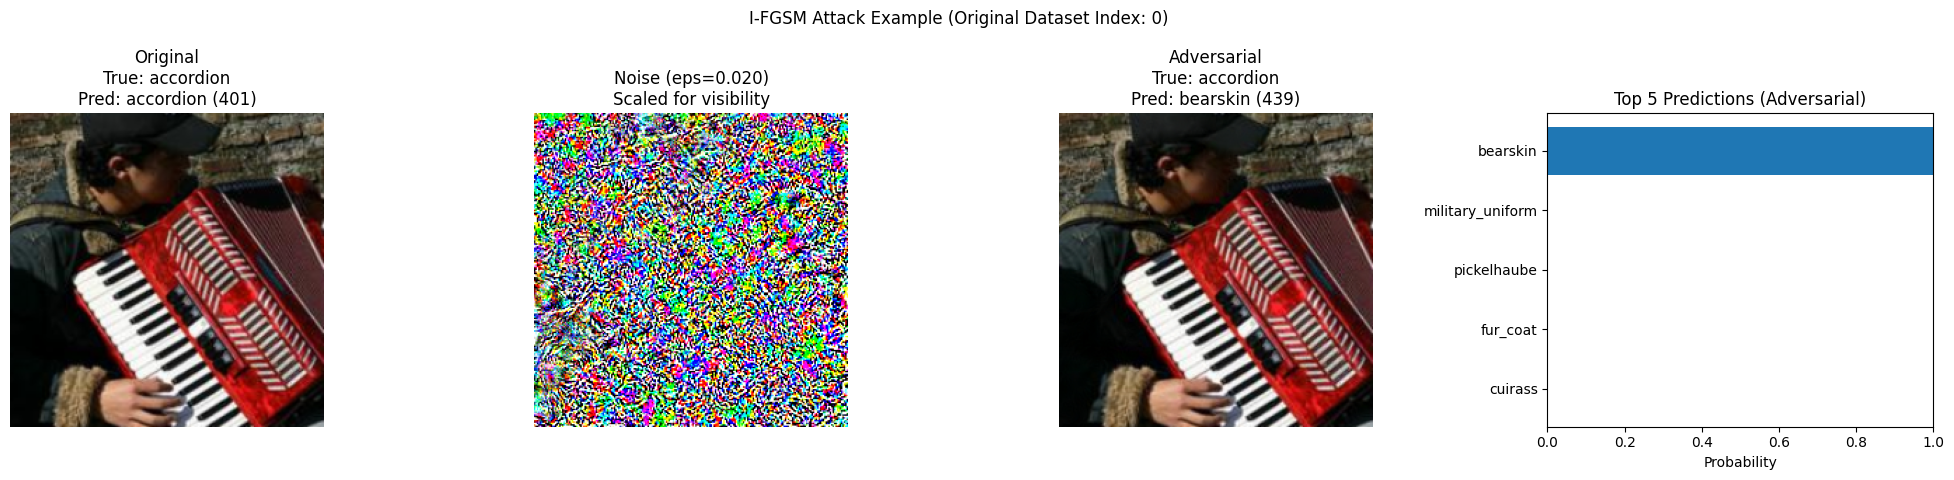

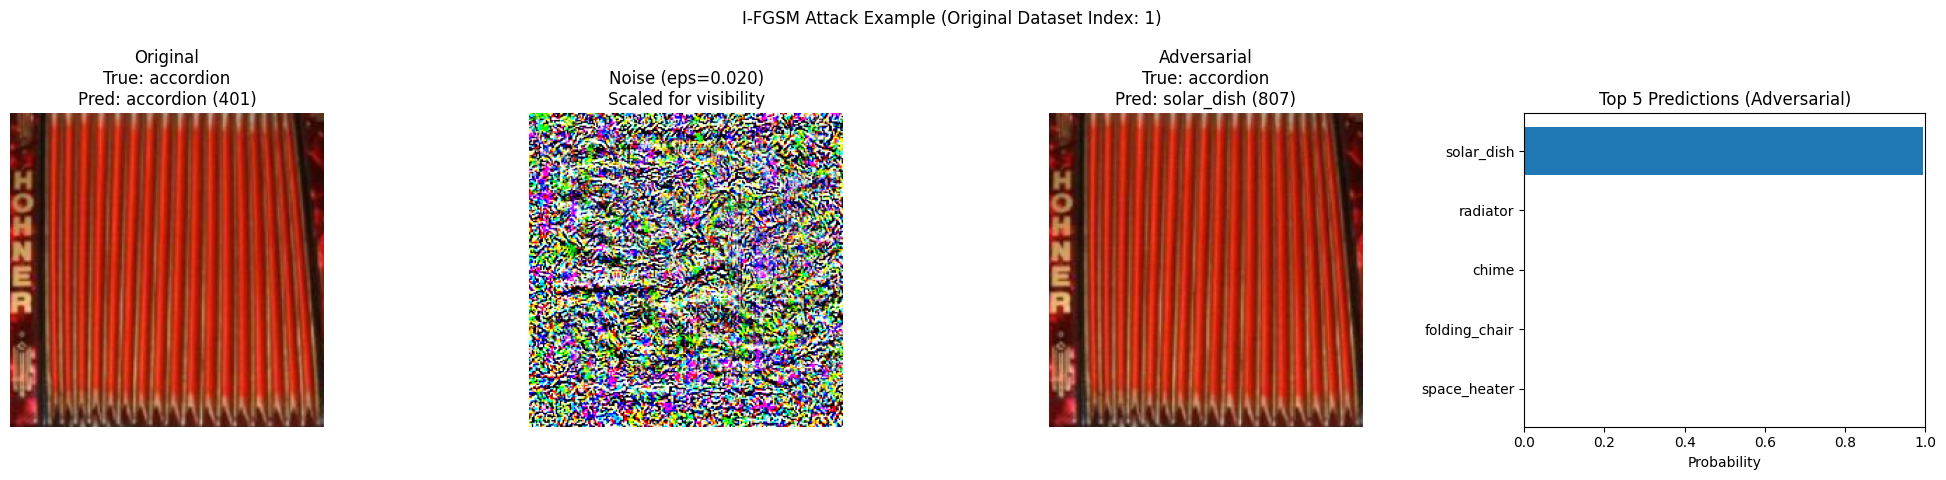

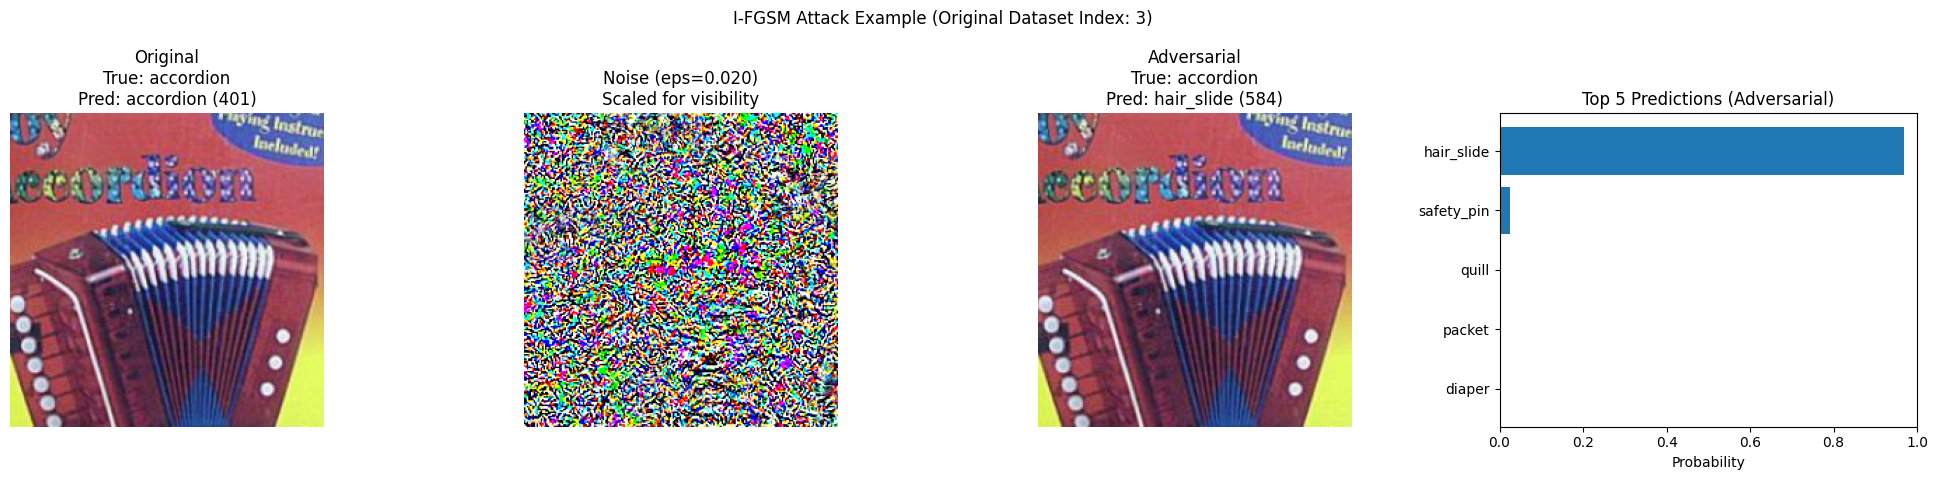

In [16]:
# --- Generate Adversarial Dataset 2 (I-FGSM) ---
print("\n--- Task 3: Generating Adversarial Dataset using I-FGSM ---")
adversarial_tensors_ifgsm = []
original_labels_list_ifgsm = []
original_indices_list_ifgsm = []

criterion_ifgsm = nn.CrossEntropyLoss()
model.eval()

batch_num_ifgsm = 0
max_linf_observed_ifgsm = 0.0

for images, labels_imagefolder in tqdm(dataloader, desc="Generating I-FGSM"):
    labels_imagenet = torch.tensor(
        [imagefolder_idx_to_imagenet_idx.get(lbl.item(), -1) for lbl in labels_imagefolder],
        dtype=torch.long
    )
    valid_mask = labels_imagenet != -1
    if not valid_mask.any():
        batch_num_ifgsm += 1
        continue

    images_valid = images[valid_mask]
    labels_imagenet_valid = labels_imagenet[valid_mask]
    labels_imagefolder_valid = labels_imagefolder[valid_mask]
    
    start_idx = batch_num_ifgsm * BATCH_SIZE
    current_batch_indices = torch.arange(len(images))[valid_mask] + start_idx

    perturbed_batch = ifgsm_attack(model, criterion_ifgsm, images_valid, labels_imagenet_valid,
                                   epsilon_ifgsm, alpha_ifgsm, num_iterations_ifgsm, device)

    delta = perturbed_batch.cpu() - images_valid.cpu()
    linf_distances = torch.linalg.norm(delta.flatten(start_dim=1), ord=float('inf'), dim=1)
    current_max_linf = torch.max(linf_distances).item()
    max_linf_observed_ifgsm = max(max_linf_observed_ifgsm, current_max_linf)

    if not torch.all(linf_distances <= epsilon_ifgsm + 1e-6):
         print(f"\nWarning: L-inf constraint potentially violated in I-FGSM batch {batch_num_ifgsm}. Max dist: {current_max_linf:.6f}")

    adversarial_tensors_ifgsm.append(perturbed_batch.cpu())
    original_labels_list_ifgsm.append(labels_imagefolder_valid.cpu())
    original_indices_list_ifgsm.extend(current_batch_indices.tolist())
    
    batch_num_ifgsm += 1

print(f"Finished generating I-FGSM adversarial examples. Max L-inf distance observed: {max_linf_observed_ifgsm:.6f}")

if adversarial_tensors_ifgsm:
    all_adversarial_tensors_ifgsm = torch.cat(adversarial_tensors_ifgsm)
    all_original_labels_ifgsm = torch.cat(original_labels_list_ifgsm)
    adv_dataset_ifgsm = TensorDataset(all_adversarial_tensors_ifgsm, all_original_labels_ifgsm)

    print(f"Saving adversarial dataset (I-FGSM) tensors to '{ADV_DATASET2_SAVE_PATH}'...")
    torch.save({
        'tensors': all_adversarial_tensors_ifgsm,
        'labels': all_original_labels_ifgsm, 
        'original_indices': original_indices_list_ifgsm 
        }, ADV_DATASET2_SAVE_PATH)
    print("I-FGSM adversarial dataset saved.")

    print("\nEvaluating model on Adversarial Test Set 2 (I-FGSM)...")
    adv_dataloader_ifgsm = DataLoader(adv_dataset_ifgsm, batch_size=BATCH_SIZE, shuffle=False)
    task3_top1_accuracy, task3_top5_accuracy = calculate_accuracy(
        model,
        adv_dataloader_ifgsm,
        device,
        imagefolder_idx_to_imagenet_idx 
    )

    print("\n--- Task 3 Results ---")
    print(f"Dataset: Adversarial Test Set 2 (I-FGSM, epsilon={epsilon_ifgsm}, iters={num_iterations_ifgsm}, alpha={alpha_ifgsm})")
    print(f"Model: ResNet-34 (ImageNet pre-trained)")
    print(f"Top-1 Accuracy: {task3_top1_accuracy:.2f}%")
    print(f"Top-5 Accuracy: {task3_top5_accuracy:.2f}%")
    print("----------------------")

    # Visualize successful I-FGSM attacks
    print("\nFinding examples of successful I-FGSM attacks for visualization...")
    successful_attack_indices_ifgsm = []
    num_to_visualize_ifgsm = 3
    adv_tensors_map_ifgsm = {orig_idx: adv_tensor for orig_idx, adv_tensor in zip(original_indices_list_ifgsm, all_adversarial_tensors_ifgsm)}
    
    checked_count_ifgsm = 0
    for i in original_indices_list_ifgsm:
        if len(successful_attack_indices_ifgsm) >= num_to_visualize_ifgsm: break
        original_image, label_imagefolder_viz = dataset[i]
        true_imagenet_idx_viz = imagefolder_idx_to_imagenet_idx.get(label_imagefolder_viz, -1)
        if true_imagenet_idx_viz == -1: continue
        if i not in adv_tensors_map_ifgsm: continue
        adversarial_image_viz = adv_tensors_map_ifgsm[i]
        orig_pred_idx_viz, _, _ = get_prediction(model, original_image, device, imagenet_idx_to_info)
        adv_pred_idx_viz, _, _ = get_prediction(model, adversarial_image_viz, device, imagenet_idx_to_info)
        if orig_pred_idx_viz == true_imagenet_idx_viz and adv_pred_idx_viz != true_imagenet_idx_viz:
            successful_attack_indices_ifgsm.append(i)
        checked_count_ifgsm += 1
        if checked_count_ifgsm % 100 == 0: print(f"Checked {checked_count_ifgsm}/{len(original_indices_list_ifgsm)} for I-FGSM visualization...")
    print(f"Found {len(successful_attack_indices_ifgsm)} I-FGSM examples to visualize.")
    for index_viz in successful_attack_indices_ifgsm:
         visualize_attack("I-FGSM", model, dataset, adv_tensors_map_ifgsm, index_viz, 
                          imagefolder_idx_to_imagenet_idx, imagenet_idx_to_info, 
                          device, epsilon_ifgsm, mean_norms, std_norms)
else:
    print("I-FGSM adversarial dataset is empty. Skipping evaluation and visualization.")

### Task 4: Patch Attacks with L2 and TV Regularization

In [31]:
# Enable cuDNN autotuner
torch.backends.cudnn.benchmark = True

# Hyperparameters
epsilon_patch        = 0.5
num_iterations_patch = 500
alpha_patch          = epsilon_patch / (num_iterations_patch / 2.5) * 2.0
patch_size           = 32
kappa                = 200.0
suppression_weight   = 5.0
l2_weight            = 0.1
tv_weight            = 0.05
kl_weight            = 0.3
perc_weight          = 0.5
momentum_decay       = 0.75
lpips_interval       = 45
restarts             = 1
ADV_SAVE_PATH = './adversial_test_set_3.pth'

In [32]:
# Load LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [33]:
# Regularization losses
def patch_l2_loss(pert, orig):
    return F.mse_loss(pert, orig, reduction='mean')

def patch_tv_loss(patch):
    tv_h = (patch[:,1:,:] - patch[:,:-1,:]).abs().mean()
    tv_w = (patch[:,:,1:] - patch[:,:,:-1]).abs().mean()
    return tv_h + tv_w

def patch_lpips_loss(pert, orig, mean_norms, std_norms, lpips_model):
    dtype, dev = pert.dtype, pert.device
    mean = torch.as_tensor(mean_norms, dtype=dtype, device=dev)[ :,None,None ]
    std  = torch.as_tensor(std_norms, dtype=dtype, device=dev)[ :,None,None ]
    def denorm(x): return x*std + mean
    p = (denorm(pert).unsqueeze(0).float()*2 - 1)
    o = (denorm(orig).unsqueeze(0).float()*2 - 1)
    return lpips_model(p, o).mean()

In [34]:
# Combined C&W + true‐suppression loss
def combined_cw_true_suppression_loss(logits, tgt_idx, true_idx, kappa, λ):
    tgt_logit = torch.gather(logits,1,tgt_idx.unsqueeze(1)).squeeze(1)
    mask = torch.zeros_like(logits, dtype=torch.bool).scatter_(1, tgt_idx.unsqueeze(1), True)
    max_other = logits.masked_fill(mask, float('-inf')).max(dim=1).values
    loss_margin = F.relu(max_other - tgt_logit + kappa)
    true_logit  = torch.gather(logits,1,true_idx.unsqueeze(1)).squeeze(1)
    return (loss_margin + λ * true_logit).mean()

# Saliency map (|∂score_true/∂pixel|)
def get_saliency_map(model, img, true_label, device):
    img = img.clone().detach().to(device).requires_grad_(True)
    out = model(img.unsqueeze(0))
    score = out[0, true_label]
    model.zero_grad(); score.backward()
    return img.grad.abs().sum(dim=0).cpu()

In [35]:
# ---------- KL helper -------------------------------------------------------
def kl_to_target(logits, target_idx, label_smooth=0.05, tau=1.0):
    """
    KL( q ‖ p_target ), where p_target is a one‑hot (optionally smoothed).
    """
    log_q = F.log_softmax(logits / tau, 1)
    with torch.no_grad():
        p = torch.full_like(log_q, fill_value=label_smooth / (log_q.size(1) - 1))
        p.scatter_(1, target_idx.unsqueeze(1), 1.0 - label_smooth)
    return F.kl_div(log_q, p, reduction='batchmean') * (tau ** 2)


In [36]:
# Main attack
def targeted_patch_pgd_full(model, base_loss_fn, image, true_label,
                            ε, α, iters, psize, l2_w, tv_w, perc_w, device,
                            restarts=1):
    model.eval()
    img_cpu = image.detach().cpu()
    img_dev = image.to(device)

    # 1) choose most‐confusing target
    with torch.no_grad():
        out = model(img_dev.unsqueeze(0))
        probs, idxs = torch.sort(F.softmax(out,1).squeeze(), descending=True)
        target = next((i.item() for i in idxs if i.item()!=true_label), idxs[0].item())
    tgt = torch.tensor([target], device=device)
    tru = torch.tensor([true_label], device=device)

    # 2) precompute saliency placement
    sal = get_saliency_map(model, img_dev, true_label, device).unsqueeze(0).unsqueeze(0).to(device)
    kernel = torch.ones((1,1,psize,psize), device=device)
    sums = F.conv2d(sal, kernel)
    flat = torch.argmax(sums)
    wdim = sums.shape[3]
    y0, x0 = (int(flat//wdim), int(flat%wdim)) if wdim>0 else (0,0)

    orig_patch = img_dev[:,y0:y0+psize,x0:x0+psize].clone()
    best_patch = orig_patch.clone()
    best_loss  = float('inf')

    for _ in range(restarts):
        pert_patch = orig_patch.clone()
        momentum   = torch.zeros_like(orig_patch)

        for it in range(iters):
            # assemble
            full = img_dev.clone()
            full[:,y0:y0+psize,x0:x0+psize] = pert_patch
            full.requires_grad_(True)

            # forward + losses
            logits    = model(full.unsqueeze(0))
            mloss     = base_loss_fn(logits, tgt, tru)
            l2_loss   = l2_w * patch_l2_loss(pert_patch, orig_patch)
            tv_loss   = tv_w * patch_tv_loss(pert_patch)
            if it % lpips_interval==0:
                perc_loss = perc_w * patch_lpips_loss(pert_patch, orig_patch,
                                                      mean_norms, std_norms, lpips_model)
            else:
                perc_loss = torch.tensor(0., device=device)
            total_loss = mloss + l2_loss + tv_loss + perc_loss

            # track best
            if total_loss.item() < best_loss:
                best_loss  = total_loss.item()
                best_patch = pert_patch.clone().detach()

            # backward
            model.zero_grad()
            total_loss.backward()
            grad_full = full.grad.data
            pg = (grad_full[0,:,y0:y0+psize,x0:x0+psize]
                  if grad_full.dim()==4 else 
                  grad_full[:,y0:y0+psize,x0:x0+psize])

            # momentum + PGD step
            momentum = momentum_decay*momentum + pg/(pg.abs().mean()+1e-12)
            step     = momentum.sign()
            pert_patch = pert_patch - α * step
            delta      = torch.clamp(pert_patch - orig_patch, -ε, ε)
            pert_patch = orig_patch + delta

            full.grad = None

    final = img_cpu.clone()
    final[:,y0:y0+psize,x0:x0+psize] = best_patch.cpu()
    return final, target, (y0,x0)

In [37]:
# --- Generate Task 4 adversarial set ---
advs, orig_idxs, tgts, coords = [], [], [], []
for i in tqdm(range(len(dataset)), desc="Task4 Attack"):
    img, lbl = dataset[i]
    true_idx = imagefolder_idx_to_imagenet_idx.get(lbl, -1)
    if true_idx < 0: continue
    adv_img, t, (y0, x0) = targeted_patch_pgd_full(
        model,
        lambda logits, tgt, tru: (
        combined_cw_true_suppression_loss(logits, tgt, tru, kappa, suppression_weight)
        + kl_weight * kl_to_target(logits, tgt)),     
        img, true_idx,
        epsilon_patch, alpha_patch, num_iterations_patch, patch_size,
        l2_weight, tv_weight, perc_weight, device,
        restarts
    )
    advs.append(adv_img)
    orig_idxs.append(i)
    tgts.append(t)
    coords.append((y0,x0))

# Save the adversarial dataset
torch.save({
    'tensors': torch.stack(advs),
    'original_indices': orig_idxs,
    'target_labels': tgts,
    'patch_coords': coords
}, ADV_SAVE_PATH)

Task4 Attack: 100%|██████████| 500/500 [56:28<00:00,  6.78s/it]


In [38]:
# Evaluate on ResNet-34
adv_dataset = torch.utils.data.TensorDataset(
    torch.stack(advs),
    torch.tensor([dataset[idx][1] for idx in orig_idxs])
)
adv_loader = torch.utils.data.DataLoader(
    adv_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=torch.cuda.is_available()
)
top1, top5 = calculate_accuracy(
    model, adv_loader, device, imagefolder_idx_to_imagenet_idx
)
print(f"Task 4 → Top-1: {top1:.2f}%, Top-5: {top5:.2f}%")

Evaluating: 100%|██████████| 16/16 [00:00<00:00, 24.22it/s]

Task 4 → Top-1: 18.20%, Top-5: 37.00%


In [39]:
def visualize_patch_attack(
    model,
    dataset,
    adv_tensors_map,
    patch_coords_map,
    target_labels_map,
    index,
    imagefolder_idx_to_imagenet_idx_map,
    imagenet_idx_to_info_map,
    device,
    epsilon_val,
    patch_size,
    mean_norms,
    std_norms
):
    """
    Displays: original image with patch‐location box, adversarial image with box,
    and a bar chart of the adversarial image’s top-5 predicted probabilities.
    """
    model.eval()

    # 1) Load original image & true label
    img_orig, lbl_folder = dataset[index]
    true_idx = imagefolder_idx_to_imagenet_idx_map.get(lbl_folder, -1)
    if true_idx < 0:
        print(f"Cannot find true label for index {index}")
        return

    # 2) Get adversarial image, patch coords & target
    if index not in adv_tensors_map:
        print(f"No adversarial tensor for index {index}")
        return
    adv_img = adv_tensors_map[index]
    y0, x0  = patch_coords_map[index]
    tgt_idx = target_labels_map[index]

    # 3) Denormalize for display
    def denorm(t):
        t = t.clone().cpu()
        for c in range(3):
            t[c] = t[c] * std_norms[c] + mean_norms[c]
        return torch.clamp(t, 0, 1)
    disp_orig = denorm(img_orig).permute(1,2,0).numpy()
    disp_adv  = denorm(adv_img  ).permute(1,2,0).numpy()

    # 4) Get model predictions
    with torch.no_grad():
        inp_orig = img_orig.unsqueeze(0).to(device)
        inp_adv  = adv_img.unsqueeze(0).to(device)
        out_orig = model(inp_orig)
        out_adv  = model(inp_adv)
        # top1 for original
        _, idx_orig = torch.max(out_orig,1)
        # top5 for adversarial
        probs_adv = torch.softmax(out_adv,1).squeeze().cpu().numpy()
        top5_idx  = np.argsort(probs_adv)[::-1][:5]
        top5_prob = probs_adv[top5_idx]

    # 5) Lookup class names
    def name_of(idx):
        info = imagenet_idx_to_info_map.get(str(idx), ["N/A","Unknown"])
        name = info[1] if isinstance(info, list) and len(info)>1 else str(info)
        return name.split(',')[0]
    orig_pred_name = name_of(idx_orig.item())
    true_name      = name_of(true_idx)
    tgt_name       = name_of(tgt_idx)
    pred5_names    = [name_of(i) for i in top5_idx]

    # 6) Plot
    fig, axes = plt.subplots(1,3,figsize=(18,6))

    # — Original w/ box
    axes[0].imshow(disp_orig)
    rect = patches.Rectangle((x0,y0),patch_size,patch_size,
                             linewidth=2,edgecolor='r',facecolor='none')
    axes[0].add_patch(rect)
    axes[0].set_title(
        f"Original\nTrue: {true_name} ({true_idx})\n"
        f"Pred: {orig_pred_name} ({idx_orig.item()})"
    )
    axes[0].axis('off')

    # — Adversarial w/ box
    axes[1].imshow(disp_adv)
    rect2 = patches.Rectangle((x0,y0),patch_size,patch_size,
                              linewidth=2,edgecolor='r',facecolor='none')
    axes[1].add_patch(rect2)
    axes[1].set_title(
        f"Adversarial (ε={epsilon_val})\n"
        f"Target: {tgt_name} ({tgt_idx})"
    )
    axes[1].axis('off')

    # — Top-5 bar chart
    axes[2].barh(np.arange(5), top5_prob, align='center')
    axes[2].set_yticks(np.arange(5))
    axes[2].set_yticklabels(pred5_names)
    axes[2].invert_yaxis()
    axes[2].set_xlabel("Probability")
    axes[2].set_title("Top-5 Predictions (Adversarial)")
    axes[2].set_xlim(0,1)

    plt.suptitle(f"Patch Attack Visualization (index={index})")
    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()

/tmp/ipykernel_31/3650001548.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(ADV_SAVE_PATH, map_location='cpu')


Visualizing 5 successful patch attack examples...


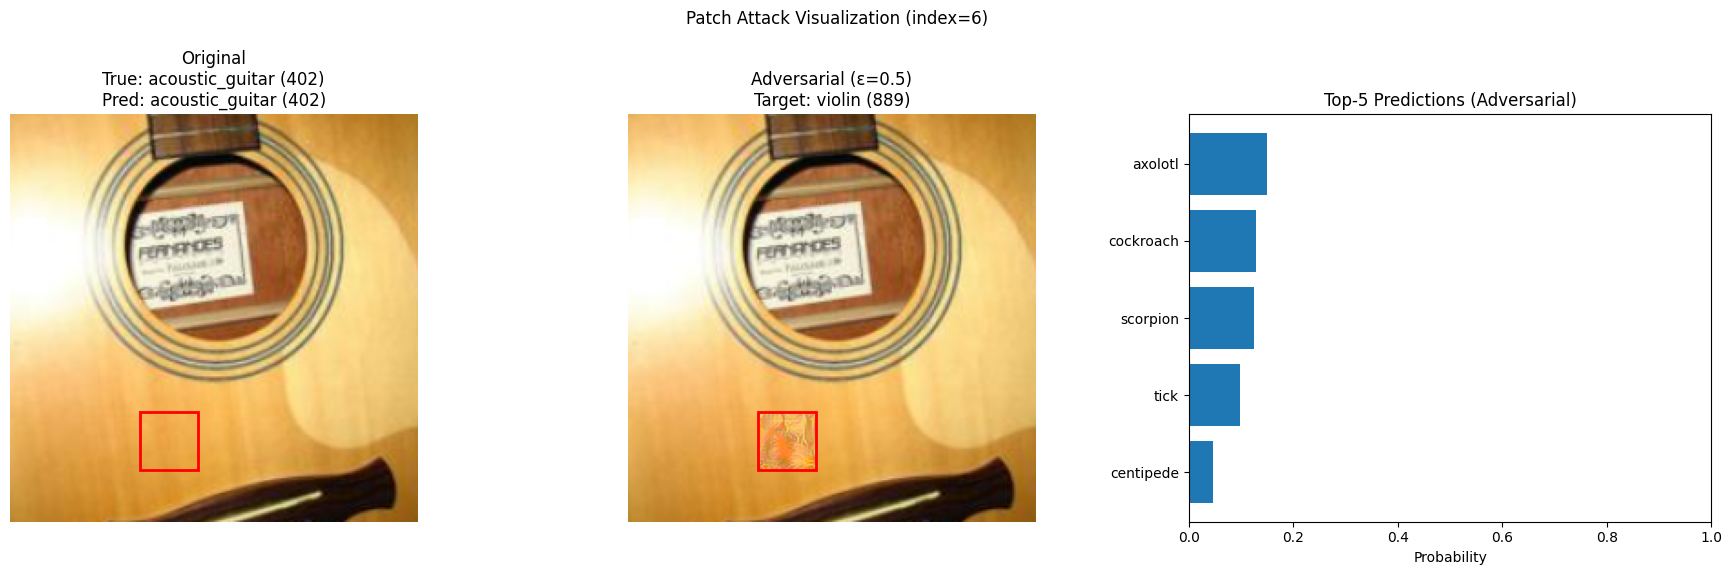

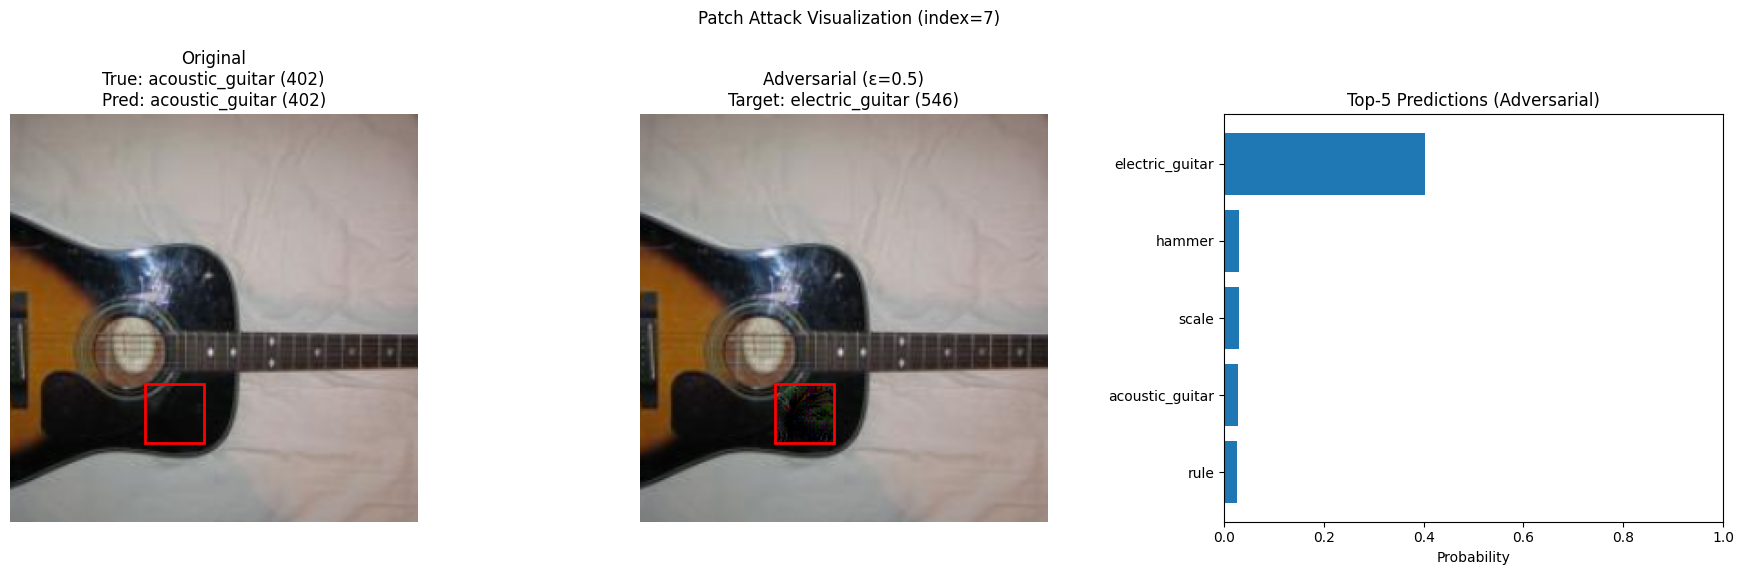

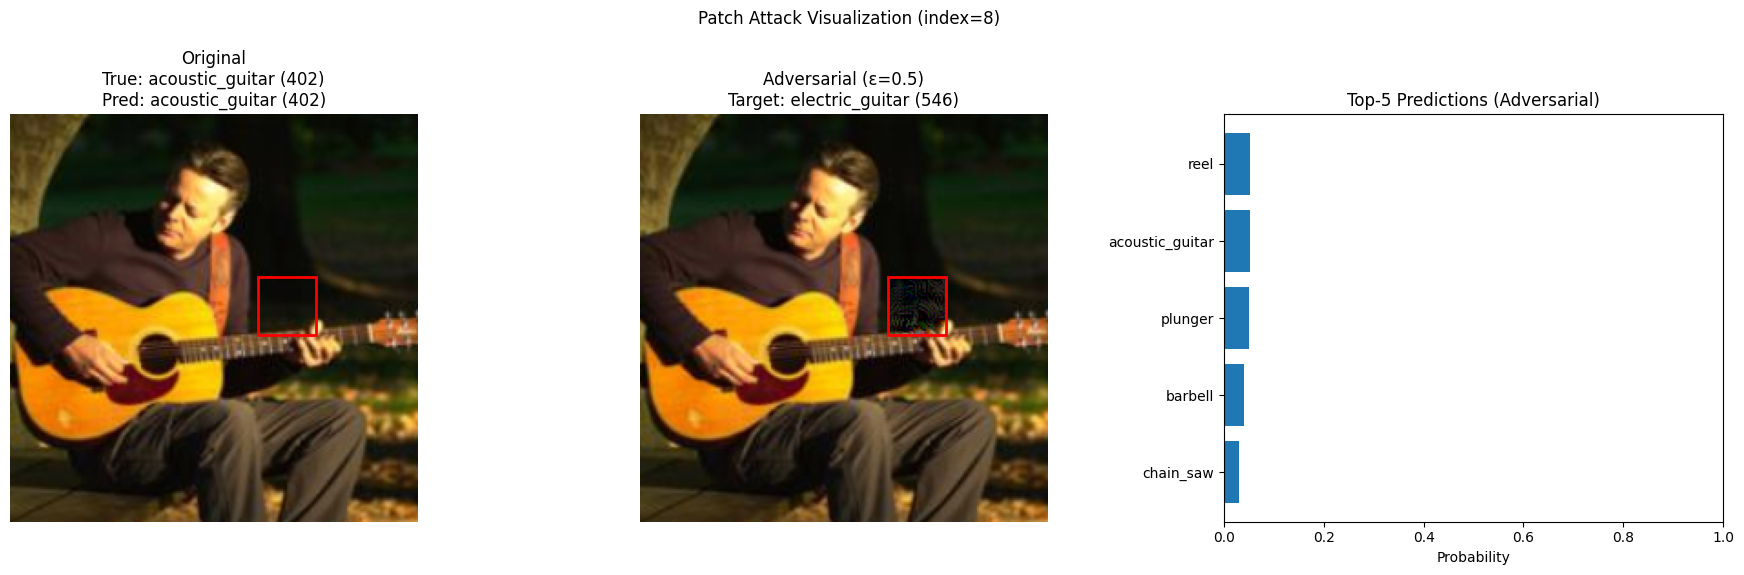

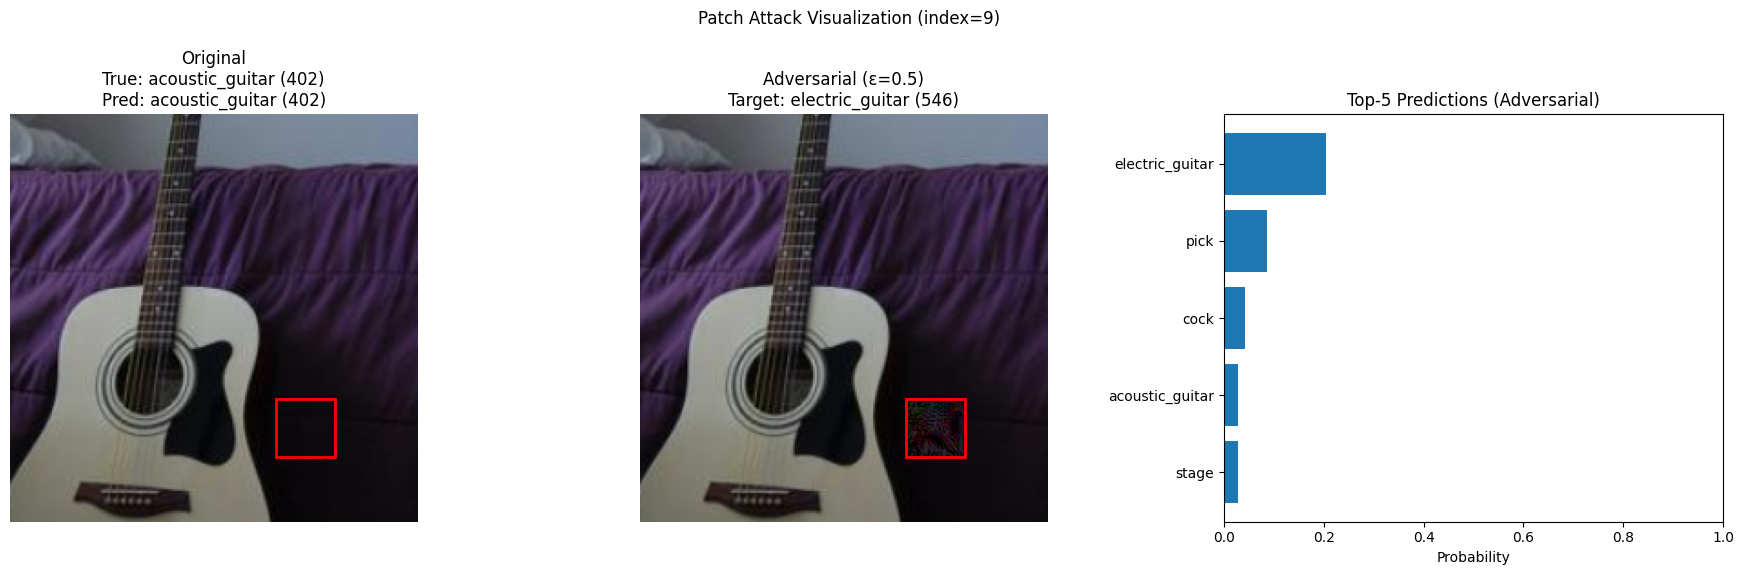

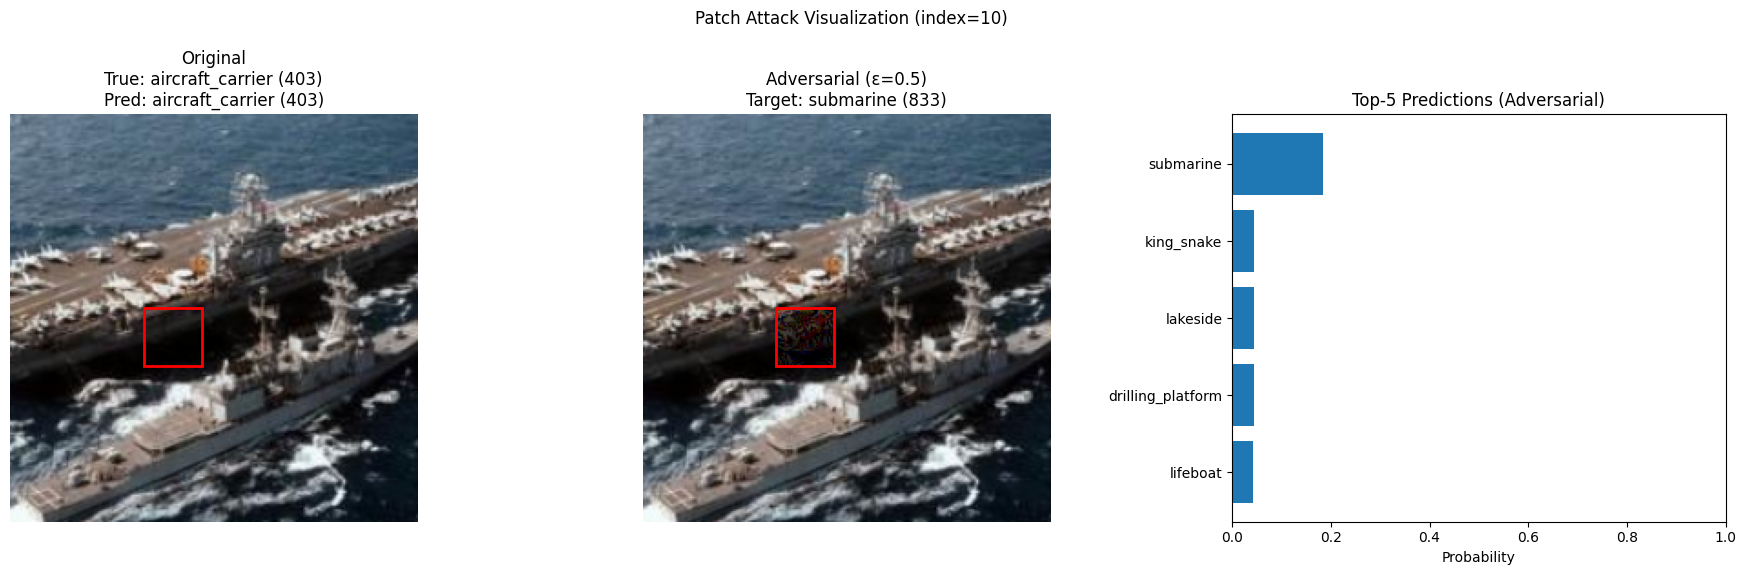

In [40]:
# Load the adversarial patch attack results
data = torch.load(ADV_SAVE_PATH, map_location='cpu')
orig_indices = data['original_indices']
adversarial_tensors = data['tensors']
patch_coords = data['patch_coords']
target_labels = data['target_labels']

# Build lookup maps
adv_tensors_map    = {idx: adversarial_tensors[i] for i, idx in enumerate(orig_indices)}
patch_coords_map   = {idx: patch_coords[i]        for i, idx in enumerate(orig_indices)}
target_labels_map  = {idx: target_labels[i]       for i, idx in enumerate(orig_indices)}

# Find successful attacks (original correct, adversarial wrong)
successful = []
for idx in orig_indices:
    original_img, folder_lbl = dataset[idx]
    true_idx = imagefolder_idx_to_imagenet_idx.get(folder_lbl, -1)
    if true_idx < 0:
        continue
    adv_img = adv_tensors_map[idx]
    orig_pred, _, _ = get_prediction(model, original_img, device, imagenet_idx_to_info)
    adv_pred, _, _ = get_prediction(model, adv_img, device, imagenet_idx_to_info)
    if orig_pred == true_idx and adv_pred != true_idx:
        successful.append(idx)
    if len(successful) >= 5:
        break

print(f"Visualizing {len(successful)} successful patch attack examples...")

# Display visualizations
for idx in successful:
    visualize_patch_attack(
        model=model,
        dataset=dataset,
        adv_tensors_map=adv_tensors_map,
        patch_coords_map=patch_coords_map,
        target_labels_map=target_labels_map,
        index=idx,
        imagefolder_idx_to_imagenet_idx_map=imagefolder_idx_to_imagenet_idx,
        imagenet_idx_to_info_map=imagenet_idx_to_info,
        device=device,
        epsilon_val=epsilon_patch,
        patch_size=patch_size,
        mean_norms=mean_norms,
        std_norms=std_norms
    )

## Saving Altered Images from Tasks

In [41]:
# --- Save all adversarial images to disk ---
print("\n--- Saving All Generated Adversarial Images to Disk ---")
OUTPUT_DIR_TASK2_IMAGES = "./AdvTestSet1_Images_FGSM"
OUTPUT_DIR_TASK3_IMAGES = "./AdvTestSet2_Images_IFGSM"
OUTPUT_DIR_TASK4_IMAGES = "./AdvTestSet3_Images_Patch"

if os.path.exists(ADV_DATASET_SAVE_PATH):
    save_adversarial_images(
        adv_data_path=ADV_DATASET_SAVE_PATH, 
        original_dataset=dataset, 
        output_root_dir=OUTPUT_DIR_TASK2_IMAGES, 
        mean_norms=mean_norms,
        std_norms=std_norms
    )
else:
    print(f"Skipping saving images for Task 2: {ADV_DATASET_SAVE_PATH} not found.")

if os.path.exists(ADV_DATASET2_SAVE_PATH):
    save_adversarial_images(
        adv_data_path=ADV_DATASET2_SAVE_PATH, 
        original_dataset=dataset, 
        output_root_dir=OUTPUT_DIR_TASK3_IMAGES, 
        mean_norms=mean_norms,
        std_norms=std_norms
    )
else:
    print(f"Skipping saving images for Task 3: {ADV_DATASET2_SAVE_PATH} not found.")

if os.path.exists(ADV_SAVE_PATH):
    save_adversarial_images(
        adv_data_path=ADV_SAVE_PATH, 
        original_dataset=dataset, 
        output_root_dir=OUTPUT_DIR_TASK4_IMAGES, 
        mean_norms=mean_norms,
        std_norms=std_norms
    )
else:
    print(f"Skipping saving images for Task 4: {ADV_SAVE_PATH} not found.")

print("Image saving process completed (if files were found).")


--- Saving All Generated Adversarial Images to Disk ---

Loading adversarial data from: ./adversarial_test_set_1.pth


/tmp/ipykernel_31/125077116.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adv_data = torch.load(adv_data_path, map_location='cpu') # Load to CPU


Loaded 500 adversarial tensors.
Saving images to: ./AdvTestSet1_Images_FGSM


Saving Images to AdvTestSet1_Images_FGSM: 100%|██████████| 500/500 [00:00<00:00, 546.97it/s]


Finished saving. Saved 500 images to ./AdvTestSet1_Images_FGSM

Loading adversarial data from: ./adversarial_test_set_2.pth
Loaded 500 adversarial tensors.
Saving images to: ./AdvTestSet2_Images_IFGSM


Saving Images to AdvTestSet2_Images_IFGSM: 100%|██████████| 500/500 [00:00<00:00, 547.62it/s]


Finished saving. Saved 500 images to ./AdvTestSet2_Images_IFGSM

Loading adversarial data from: ./adversial_test_set_3.pth
Loaded 500 adversarial tensors.
Saving images to: ./AdvTestSet3_Images_Patch


Saving Images to AdvTestSet3_Images_Patch: 100%|██████████| 500/500 [00:00<00:00, 546.38it/s]

Finished saving. Saved 500 images to ./AdvTestSet3_Images_Patch
Image saving process completed (if files were found).


### Task 5: Transferring Attacks

In [42]:
# --- 1) Load a new model (DenseNet-121) ---
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device).eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 150MB/s] 


In [43]:
# --- 2) Helper to load an adversarial dataset from a .pth file ---
def load_adv_loader(path, batch_size=BATCH_SIZE):
    data = torch.load(path, map_location='cpu')
    # we assume each file has 'tensors' and either 'labels' or 'original_indices'→use the original dataset labels
    if 'labels' in data:
        ds = TensorDataset(data['tensors'], data['labels'])
    else:
        # fallback: use the imagefolder labels from the original indices
        labels = torch.tensor([dataset[i][1] for i in data['original_indices']])
        ds = TensorDataset(data['tensors'], labels)
    return DataLoader(ds, batch_size=batch_size, shuffle=False,
                      num_workers=2, pin_memory=torch.cuda.is_available())

In [44]:
# --- 3) Instantiate all four loaders ---
orig_loader = dataloader                                         # your clean test set
fgsm_loader = load_adv_loader(ADV_DATASET_SAVE_PATH)             # Task 2 FGSM  
ifgsm_loader = load_adv_loader(ADV_DATASET2_SAVE_PATH)           # Task 3 I-FGSM  
patch_loader = load_adv_loader(ADV_SAVE_PATH)  # Task 4 Patch

/tmp/ipykernel_31/1562712473.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_location='cpu')


In [45]:
def calculate_accuracy(model, dataloader, device, imagefolder_idx_to_imagenet_idx_map):
    model.eval()
    total = 0
    correct_top1 = 0
    correct_top5 = 0

    with torch.no_grad():
        for inputs, labels_folder in tqdm(dataloader, desc="Evaluating"):
            # Move inputs to device
            inputs = inputs.to(device)

            # Forward pass
            outputs = model(inputs)  # shape (B, 1000)

            # Get top-5 predictions for each sample
            _, pred_top5 = torch.topk(outputs, k=5, dim=1)  # shape (B, 5)
            pred_top5 = pred_top5.cpu()

            # Map ImageFolder labels to ImageNet labels
            true_imagenet = torch.tensor(
                [imagefolder_idx_to_imagenet_idx_map.get(lbl.item(), -1)
                 for lbl in labels_folder],
                dtype=torch.long
            )

            # Filter out unmapped samples
            mask = (true_imagenet >= 0)
            if not mask.any():
                continue

            pred_top5 = pred_top5[mask]
            true_imagenet = true_imagenet[mask]

            batch_size = true_imagenet.size(0)
            total += batch_size

            # Top-1: how many times the first prediction equals the true label
            correct_top1 += (pred_top5[:, 0] == true_imagenet).sum().item()

            # Top-5: how many times true label is anywhere in the top-5
            correct_top5 += (pred_top5 == true_imagenet.unsqueeze(1)).any(dim=1).sum().item()

    if total == 0:
        return 0.0, 0.0

    accuracy_top1 = 100.0 * correct_top1 / total
    accuracy_top5 = 100.0 * correct_top5 / total
    return accuracy_top1, accuracy_top5

In [46]:
# --- 5) Run all four evaluations ---
print("\nEvaluating on DenseNet-121:")
orig_top1, orig_top5   = calculate_accuracy(new_model, orig_loader,   device, imagefolder_idx_to_imagenet_idx)
fgsm_top1, fgsm_top5   = calculate_accuracy(new_model, fgsm_loader,   device, imagefolder_idx_to_imagenet_idx)
ifgsm_top1, ifgsm_top5 = calculate_accuracy(new_model, ifgsm_loader,  device, imagefolder_idx_to_imagenet_idx)
patch_top1, patch_top5 = calculate_accuracy(new_model, patch_loader,  device, imagefolder_idx_to_imagenet_idx)

print(f"\n{'Dataset':<20}   | {'Top-1 (%)':>8}  | {'Top-5 (%)':>8}")
print("-"*40)
print(f"{'Original':<20}    | {orig_top1:8.2f}  | {orig_top5:8.2f}")
print(f"{'FGSM':<20}        | {fgsm_top1:8.2f}  | {fgsm_top5:8.2f}")
print(f"{'I-FGSM':<20}      | {ifgsm_top1:8.2f} | {ifgsm_top5:8.2f}")
print(f"{'Patch Attack':<20}| {patch_top1:8.2f} | {patch_top5:8.2f}")


Evaluating on DenseNet-121:


Evaluating: 100%|██████████| 16/16 [00:01<00:00, 14.97it/s]


Dataset                | Top-1 (%)  | Top-5 (%)
----------------------------------------
Original                |    70.80  |    91.20
FGSM                        |    58.80  |    85.00
I-FGSM                    |    58.40 |    86.20
Patch Attack        |    63.80 |    86.20
